In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd


In [ ]:
#drop when user_verified is false
#df_tweets = df_tweets[df_tweets['user_verified'] == True]
#drop when user_followers is less than 1000000
df_tweets['user_followers'] = pd.to_numeric(df_tweets['user_followers'], errors='coerce')

# Now, drop any rows where 'user_followers' is NaN
df_tweets = df_tweets.dropna(subset=['user_followers'])

# Convert the 'user_followers' column to integer
df_tweets['user_followers'] = df_tweets['user_followers'].astype(int)
#print length of dataframe  

In [ ]:
# drop when user_followers is less than 1000000
df_tweets_light = df_tweets[df_tweets['user_followers'] > 10000]

In [ ]:
df_tweets_light.to_csv('Bitcoin_tweets_light.csv', index=False)

In [ ]:
df_tweets_light = df_tweets_light.sort_values(by='date', ascending=True)

In [ ]:
# number of rows in dataframe
print(len(df_tweets))

In [ ]:
df_tweets

In [4]:
bitcoin = pd.read_csv('BTCUSD25052023.csv', index_col='Date', parse_dates=True).sort_values(by='Date', ascending=True)

In [6]:
# diff day to day price
bitcoin['diff'] = bitcoin['BTCUSD'].diff()


In [9]:
tweets = pd.read_csv('Data/Bitcoin_tweets_light.csv', index_col='date', parse_dates=True, low_memory=False).sort_values(by='date', ascending=True)

In [37]:
sentiments1 = pd.read_csv('Data/Bitcoin_tweets_sentiment.csv', low_memory=False)
sentiments2 = pd.read_csv('Data/Bitcoin_tweets_sentiment2.csv', low_memory=False)

sentiments = pd.concat([sentiments1[:250000], sentiments2]).reset_index(drop=True)
len(sentiments)
sentiments.to_csv('Data/Bitcoin_tweets_sentiment_total.csv', index=False)


In [28]:
tweets['sentiment'][:394434] = sentiments['sentiment']
tweets['sentiment'] = tweets['sentiment'].replace( {1: 1, 0: -1} )

/var/folders/8b/6fmv5pg97ysfwd54yr90g5z80000gn/T/ipykernel_26550/3950793788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['sentiment'][:394434] = sentiments['sentiment']


In [31]:
tweets['reach'] = tweets['user_followers'] * tweets['sentiment']/tweets['user_followers'].max()

In [33]:
day_sentiment= tweets.groupby(tweets.index.date)['reach'].sum()

In [5]:
from transformers import TextClassificationPipeline, AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
from tqdm import tqdm
model_name = "ElKulako/cryptobert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, max_length=128, truncation=True, padding = 'max_length')

df = pd.read_csv('Data/Bitcoin_tweets_light_cleaned.csv', index_col='date', parse_dates=True)
df = df[df['user_followers'] > 500000]
df['text'] = df['text'].str[:128]





In [ ]:
tweet_corpus_text = df['text'].dropna().to_list()
print(len(tweet_corpus_text))
results = []
chunk = 500

def data_generator(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        yield data[i:i+chunk_size]

for batch in tqdm(data_generator(tweet_corpus_text, chunk)):
    result_chunk = pipe(batch) 
    results.extend(result_chunk)
    results_df = pd.DataFrame(results, columns=['sentiment'])
    results_df.to_csv('Data/Bitcoin_tweets_cryptobert.csv', index=False)

In [24]:
df = pd.read_csv('Data/Bitcoin_tweets_light_cleaned.csv')
df = df[df['user_followers'] > 500000]
df.dropna(inplace=True)

In [25]:
results_df = pd.read_csv('Data/Bitcoin_tweets_sentiment_500000.csv')
results_df['sentiment'] = results_df['sentiment'].replace( {1: 1, 0: -1} )


In [26]:
df['sentiment'] = results_df['sentiment'].to_list()

In [27]:
df['reach'] = df['user_followers'] * df['sentiment']/df['user_followers'].max()
df.set_index('date', inplace=True)

In [28]:
df.sort_index(inplace=True)

In [29]:
df.index = pd.to_datetime(df.index)

In [30]:
df.index = df.index.normalize()

In [31]:
df

,user_followers,text,sentiment,reach
date,,,,
2021-02-05,731739,have you seen our bitcoin analytics page learn...,1,0.030323
2021-02-06,731726,and we are back over k again when do you think...,1,0.030323
2021-02-06,1471998,hedge fund pushes back on s claim that etf wou...,1,0.060999
2021-02-06,1471998,cme group s chief economist calls bitcoin an e...,-1,-0.060999
2021-02-06,628602,regardless of what happens to the price of bit...,1,0.026049
...,...,...,...,...
2023-01-09,2803231,bitcoin ukele ucks are here limited number rem...,1,0.116166
2023-01-09,656451,btc may face a lot of headwinds during the nex...,1,0.027203
2023-01-09,505408,should ve kept chf and also bought some bitcoin,1,0.020944


In [32]:
df.groupby(['date'])['reach'].sum()

date
2021-02-05    0.030323
2021-02-06    0.056372
2021-02-07    0.028125
2021-02-08    0.434819
2021-02-09    0.264561
                ...   
2022-12-25    0.409988
2022-12-27    0.032745
2023-01-06    0.006273
2023-01-07    0.670112
2023-01-09    2.222467
Name: reach, Length: 213, dtype: float64

In [33]:
day_sentiment = df.groupby(['date'])['reach'].sum()
day_sentiment.to_csv('Data/daily_sentiment.csv', index=True)

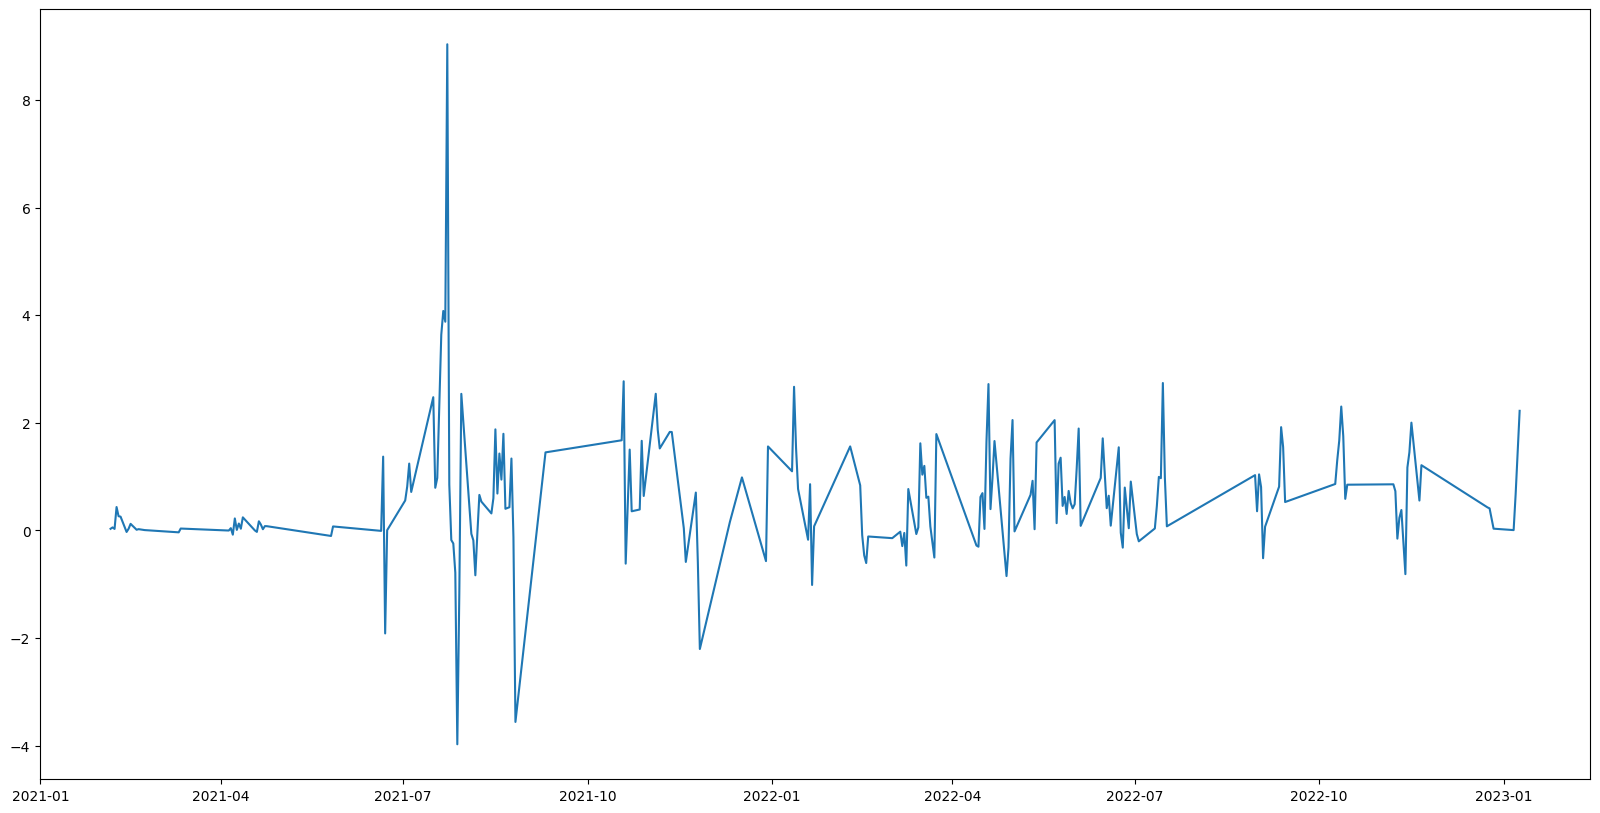

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(day_sentiment)
plt.show()


In [35]:
df_bitcoin= pd.read_csv('Data/BTC-USD.csv', index_col='Date', parse_dates=True).sort_values(by='Date', ascending=True)
# match dates between bitcoin and day_sentiment
df_bitcoin = df_bitcoin[df_bitcoin.index.isin(day_sentiment.index)]

df_bitcoin['diff'] = df_bitcoin['Close'].diff().shift(-1)/df_bitcoin['Close']

# calculate the correlation between df_bitcoin['diff'] and day_sentiment
df_bitcoin['diff'].corr(day_sentiment)

# plot df_bitcoin['diff'] = np.sign(df_bitcoin['Close'].diff().shift(-1))
plt.figure(figsize=(20,10))
plt.plot(df_bitcoin['diff']/(df_bitcoin['diff'].max()))
plt.plot(day_sentiment/(day_sentiment.max()))
plt.show()

In [36]:
df_bitcoin['diff'] = df_bitcoin['Close'].diff().shift(-1)/df_bitcoin['Close']

# calculate the correlation between df_bitcoin['diff'] and day_sentiment
df_bitcoin['diff'].corr(day_sentiment)

# plot df_bitcoin['diff'] = np.sign(df_bitcoin['Close'].diff().shift(-1))
plt.figure(figsize=(20,10))
plt.plot(df_bitcoin['diff']/(df_bitcoin['diff'].max()))
plt.plot(day_sentiment/(day_sentiment.max()))
plt.show()

0.06212005800222686

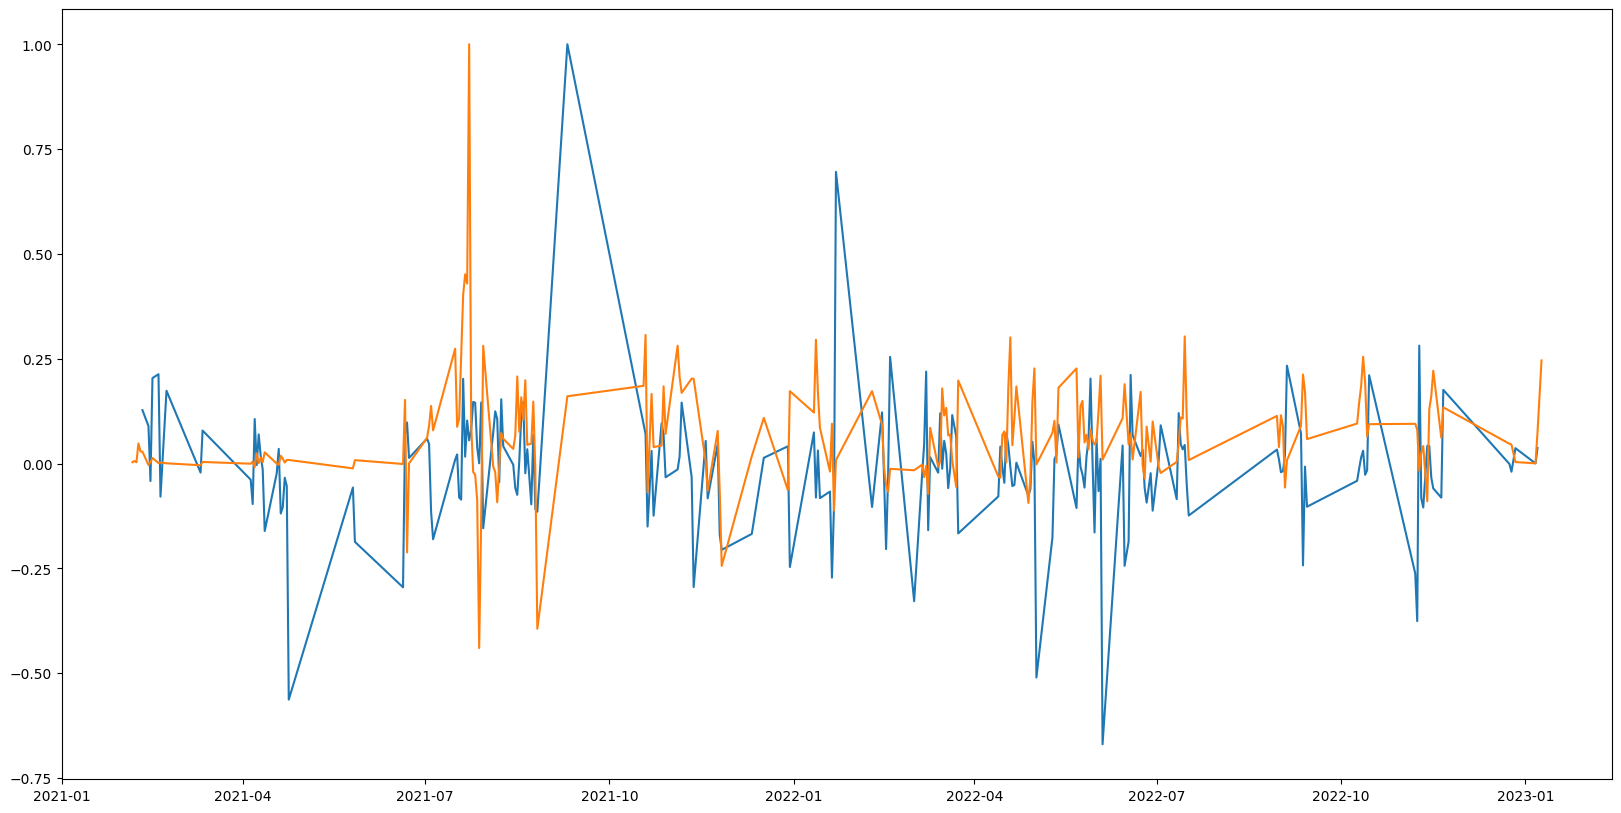

In [37]:
# plot df_bitcoin['diff'] = np.sign(df_bitcoin['Close'].diff().shift(-1))
plt.figure(figsize=(20,10))
plt.plot(df_bitcoin['diff']/(df_bitcoin['diff'].max()))
plt.plot(day_sentiment/(day_sentiment.max()))
plt.show()

In [38]:
df_original = pd.read_csv('Data/Bitcoin_tweets_light.csv', index_col='date', parse_dates=True, low_memory=False).sort_values(by='date', ascending=True)